In [467]:
import numpy as np                            # numpy is for math (it's hyper fast)
from plot_robot import *                      # custom plotting functions for robot
from kinematics import *                      # custom kinematic functions
from cspline import *                         # custom cubic spline functions
from rrt_connect import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [468]:
def get_dh_param_table(q):
    '''
    Returns a table containing the Denavit-Hartenberg parameters,
    with the row i having the following pattern: [theta_i, alpha_i, r_i, d_i].
    In contrast to the lecture, i starts at zero (because informatics..)
    The values of this table depend on the robot's current configuration q.

    Also the indices of the configuraion vector q start at zero.
    Thus, what we called theta_1 in the lecture is here q[0].
    '''
    LINK_LENGTH_1  = 4
    LINK_LENGTH_2  = 3
    LINK_LENGTH_3  = 2   
    LINK_LENGTH_4  = 0.5
    
    return np.array([
        [q[0],      0.0,  LINK_LENGTH_1,     0.0],
        [q[1],      0.0,  LINK_LENGTH_2,     0.0],
#        [q[2],      0.0,  LINK_LENGTH_3,     0.0],
#        [q[3],      0.0,  LINK_LENGTH_4,     0.0],
    ])
# ---

kinematics = Kinematics(get_dh_param_table, q_min=-np.pi * np.ones(2), q_max=np.pi * np.ones(2))

In [469]:
def get_obstacles() -> list:
    box1 = np.array([-1, 5, 5, 3])
    box2 = np.array([0, 1.5, 5, 2])
    return [box1]
# ---

In [470]:
def plot_obstacles(boxes:list) -> None:
    for box in boxes:
        plt.gca().add_patch(Rectangle((box[0], box[1]), box[2], box[3]))

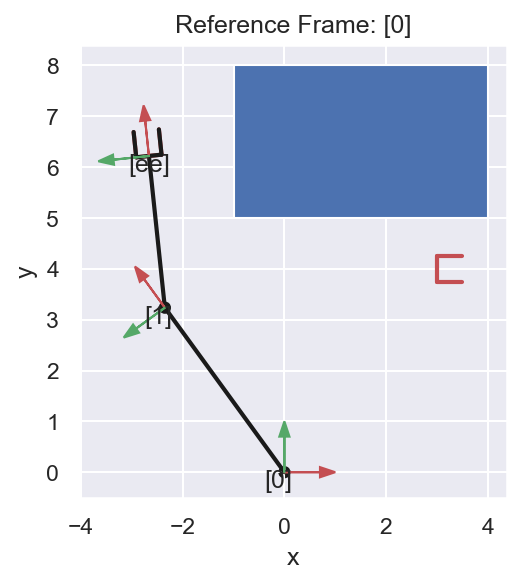

In [471]:
# generate environment
obstacles     = get_obstacles()

# specify initial robot configuration
q_init = np.array([np.pi*0.7, -np.pi/6])

start_pose = kinematics.forward_kinematics(q_init)
goal_pose  = np.array([ 3, 4, 0, 0, 0, 0])
#goal_pose  = np.array([ 2, 6, 0, 0, 0, np.pi/2])


target_poses = np.array([start_pose, goal_pose])

plot_robot_dh(frames=kinematics.get_frames_for_configuration(q_init), target_poses=target_poses, do_show=False)
plot_obstacles(obstacles)

In [483]:
rrt = RRT_Connect(q_init, goal_pose, kinematics, obstacles, q_thresh=0.2, goal_bias=0.05)

In [484]:
path = rrt.perform_search(check_self_collision=True, n_steps=1500, step_size=0.1)
rrt.tree.X.shape

goal reached


(254, 6)

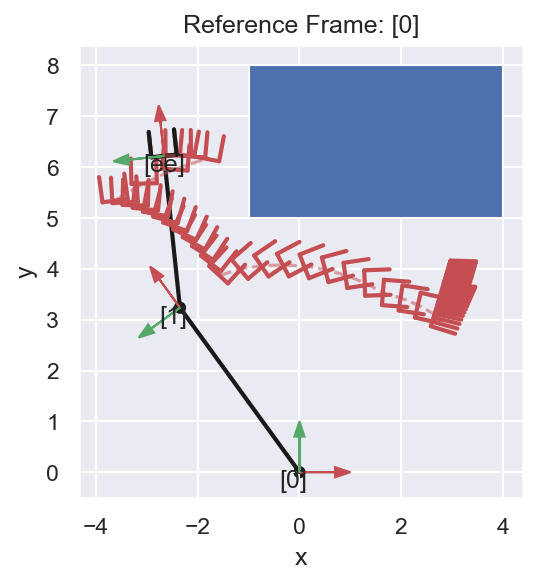

In [485]:
conf_path = np.array([node.q for node in path])
pose_path = np.array([node.x for node in path])

durations = np.ones(len(pose_path)-1)


n_pts          = 200
ts             = np.linspace(0, np.sum(durations), n_pts)

conf_coeffs    = np.array(create_multi_point_cspline_interpolation(conf_path, durations))
conf_pos, _, _ = eval_multi_point_spline_interpolation(ts, conf_path, durations, conf_coeffs)
pose_pos = np.array([kinematics.forward_kinematics(q) for q in conf_pos.reshape(n_pts, len(q_init))])

plot_robot_dh(frames=kinematics.get_frames_for_configuration(q_init), target_poses=pose_path, interp_xs=pose_pos[:, 0], interp_ys=pose_pos[:, 1], do_show=False)
plot_obstacles(obstacles)


In [486]:
# reset robot
t  = 0
dt = 5
q  = np.copy(q_init)

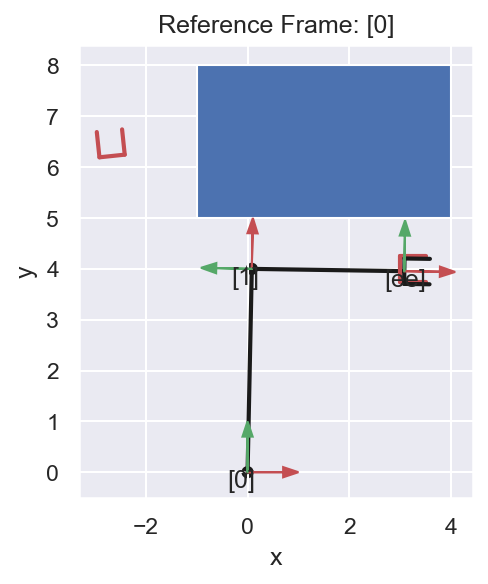

In [466]:
#target_pose = pos[np.min([t, len(pos)-1])].flatten()
q = conf_pos[np.min([t, len(conf_pos)-1])].flatten()#kinematics.perform_step(q, target_pose, step_size=0.1)
t += dt

plot_robot_dh(frames=kinematics.get_frames_for_configuration(q), target_poses=[start_pose, goal_pose], interp_xs=None, interp_ys=None, do_show=False)
#plot_robot_dh(frames=kinematics.get_frames_for_configuration(q), target_poses=[start_pose, goal_pose], interp_xs=pose_pos[:, 0], interp_ys=pose_pos[:, 1], do_show=False)
plot_obstacles(obstacles)

In [307]:
n_samples = 100
q1s       = np.linspace(-np.pi, np.pi, n_samples)
q2s       = np.linspace(-np.pi, np.pi, n_samples)
C_obs     = np.zeros((n_samples, n_samples))

for i1, q1 in enumerate(q1s):
    for i2, q2 in enumerate(q2s):
        q = np.array([q1, q2])
        if kinematics.self_collision(q):
            C_obs[i2, i1] = 1
        elif kinematics.robot_inside_obstacles(obstacles, q):
            C_obs[i2, i1] = 2

In [308]:
C_obs

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

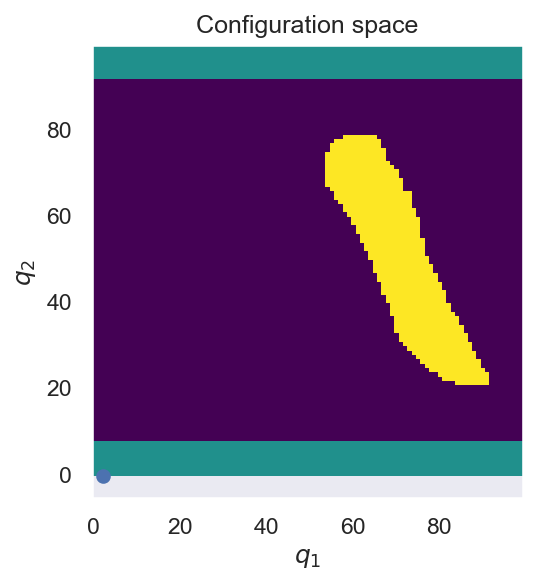

In [313]:

plt.figure(dpi=150)
plt.imshow(C_obs, cmap='viridis', origin='lower')
plt.grid(False)
plt.title('Configuration space')
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')

plt.scatter([q_init[0]], [q_init[1]])

In [312]:
q_init

array([ 2.19911486, -0.52359878])